In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2024-10-15 09:11:42.879032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 09:11:42.892980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 09:11:42.897292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1728983504.188525  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

I0000 00:00:1728983510.034903  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/10


I0000 00:00:1728983512.525719  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['emission_kernel_0', 'emission_kernel_1', 'emission_kernel_2', 'emission_kernel_3', 'transition_kernel_begin_to_match_0', 'transition_kernel_match_to_end_1', 'transition_kernel_match_to_match_2', 'transition_kernel_match_to_insert_3', 'transition_kernel_insert_to_match_4', 'transition_kernel_insert_to_insert_5', 'transition_kernel_match_to_delete_6', 'transition_kernel_delete_to_match_7', 'transition_kernel_delete_to_delete_8', 'transition_kernel_left_flank_loop_9', 'transition_kernel_left_flank_exit_10', 'transition_kernel_una

17/17 - 23s - 1s/step - loss: 87.0031 - loglik: -8.0487e+01 - prior: -6.5160e+00 - aux_loss: 0.0000e+00
Epoch 2/10
17/17 - 5s - 267ms/step - loss: 70.0811 - loglik: -6.7296e+01 - prior: -2.7848e+00 - aux_loss: 0.0000e+00
Epoch 3/10
17/17 - 5s - 277ms/step - loss: 67.7155 - loglik: -6.5881e+01 - prior: -1.8350e+00 - aux_loss: 0.0000e+00
Epoch 4/10
17/17 - 5s - 295ms/step - loss: 66.1900 - loglik: -6.4665e+01 - prior: -1.5247e+00 - aux_loss: 0.0000e+00
Epoch 5/10
17/17 - 7s - 414ms/step - loss: 66.3583 - loglik: -6.5046e+01 - prior: -1.3123e+00 - aux_loss: 0.0000e+00


I0000 00:00:1728983560.109808  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: [(12, 2), (14, 1), (19, 1)]
discards model 0: []
expansions model 1: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 1)]
discards model 1: []
expansions model 2: [(12, 4), (13, 2), (16, 1), (18, 1)]
discards model 2: []
expansions model 3: [(10, 1), (11, 2), (12, 3), (13, 1), (16, 1), (18, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [32, 33, 32, 33] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728983564.740231  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/2


I0000 00:00:1728983566.691509  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


17/17 - 27s - 2s/step - loss: 67.4181 - loglik: -6.1541e+01 - prior: -5.8775e+00 - aux_loss: 0.0000e+00
Epoch 2/2
17/17 - 5s - 300ms/step - loss: 63.3446 - loglik: -6.0950e+01 - prior: -2.3942e+00 - aux_loss: 0.0000e+00


I0000 00:00:1728983599.887790  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: []
discards model 0: [12]
expansions model 1: []
discards model 1: [12]
expansions model 2: []
discards model 2: [17]
expansions model 3: []
discards model 3: [12]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 32, 31, 32] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728983604.865409  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/2


I0000 00:00:1728983606.858489  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


17/17 - 24s - 1s/step - loss: 65.8899 - loglik: -6.0429e+01 - prior: -5.4613e+00 - aux_loss: 0.0000e+00
Epoch 2/2
17/17 - 5s - 303ms/step - loss: 62.7119 - loglik: -6.0597e+01 - prior: -2.1149e+00 - aux_loss: 0.0000e+00


I0000 00:00:1728983646.709808  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


expansions model 0: []
discards model 0: []
expansions model 1: []
discards model 1: [15]
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: [15]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.05882353 ... 0.05555556 0.03030303 0.25      ] .
Using 0 GPUs.


I0000 00:00:1728983651.742354  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/10


I0000 00:00:1728983653.740482  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


17/17 - 23s - 1s/step - loss: 65.2941 - loglik: -6.0441e+01 - prior: -4.8536e+00 - aux_loss: 0.0000e+00
Epoch 2/10
17/17 - 5s - 278ms/step - loss: 62.3940 - loglik: -6.0727e+01 - prior: -1.6667e+00 - aux_loss: 0.0000e+00
Epoch 3/10
17/17 - 5s - 277ms/step - loss: 61.1642 - loglik: -6.0413e+01 - prior: -7.5156e-01 - aux_loss: 0.0000e+00
Epoch 4/10
17/17 - 5s - 275ms/step - loss: 61.7826 - loglik: -6.1493e+01 - prior: -2.8916e-01 - aux_loss: 0.0000e+00
Time for alignment: 182.2551
Likelihoods:  ['-0.1317', '-0.1317', '-0.1317', '-0.1317']
Mean likelihood:  -0.1316643384418728
Selection criterion: AIC
Best model:  0 (0-based)


I0000 00:00:1728983695.519878  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 3.0047
Wrote file test/data/interactive.alignment.fasta
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step
>l=-54.50_t=0.01
.........$CD.......P............NP.........CYN.HGT..C...S........L.R......................A...T........G..........YTCSCL.P.R......Y......TGEH$.......................
>l=-55.66_t=0.01
.........$CD.......S............QP.........CRN.-GT..C...Sl.......N.T......................N...T........D..........YTCACF.P.G......Y......TGRY$.......................
>l=-49.88_t=0.01
.........$CD.......S............DP.........CLN.GGT..C...T........L.R......................Sl..D........S..........YSCACA.P.G......Y......TGQH$.......................
>l=-63.11_t=0.01
.........$CD.......H............VT.........CLN.GGT..C...Q........LkT......................L...E........D..........YTCACA.N.G......Y......TGER$.......................
>l=-63.78_t=0.01
.........$CD.......H............VT.........CLN.GGT..C...Q........LkT......................L...E........E..........YTCACA.N.G..

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1728983706.008431  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728983706.183689  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728983706.325094  151265 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but 

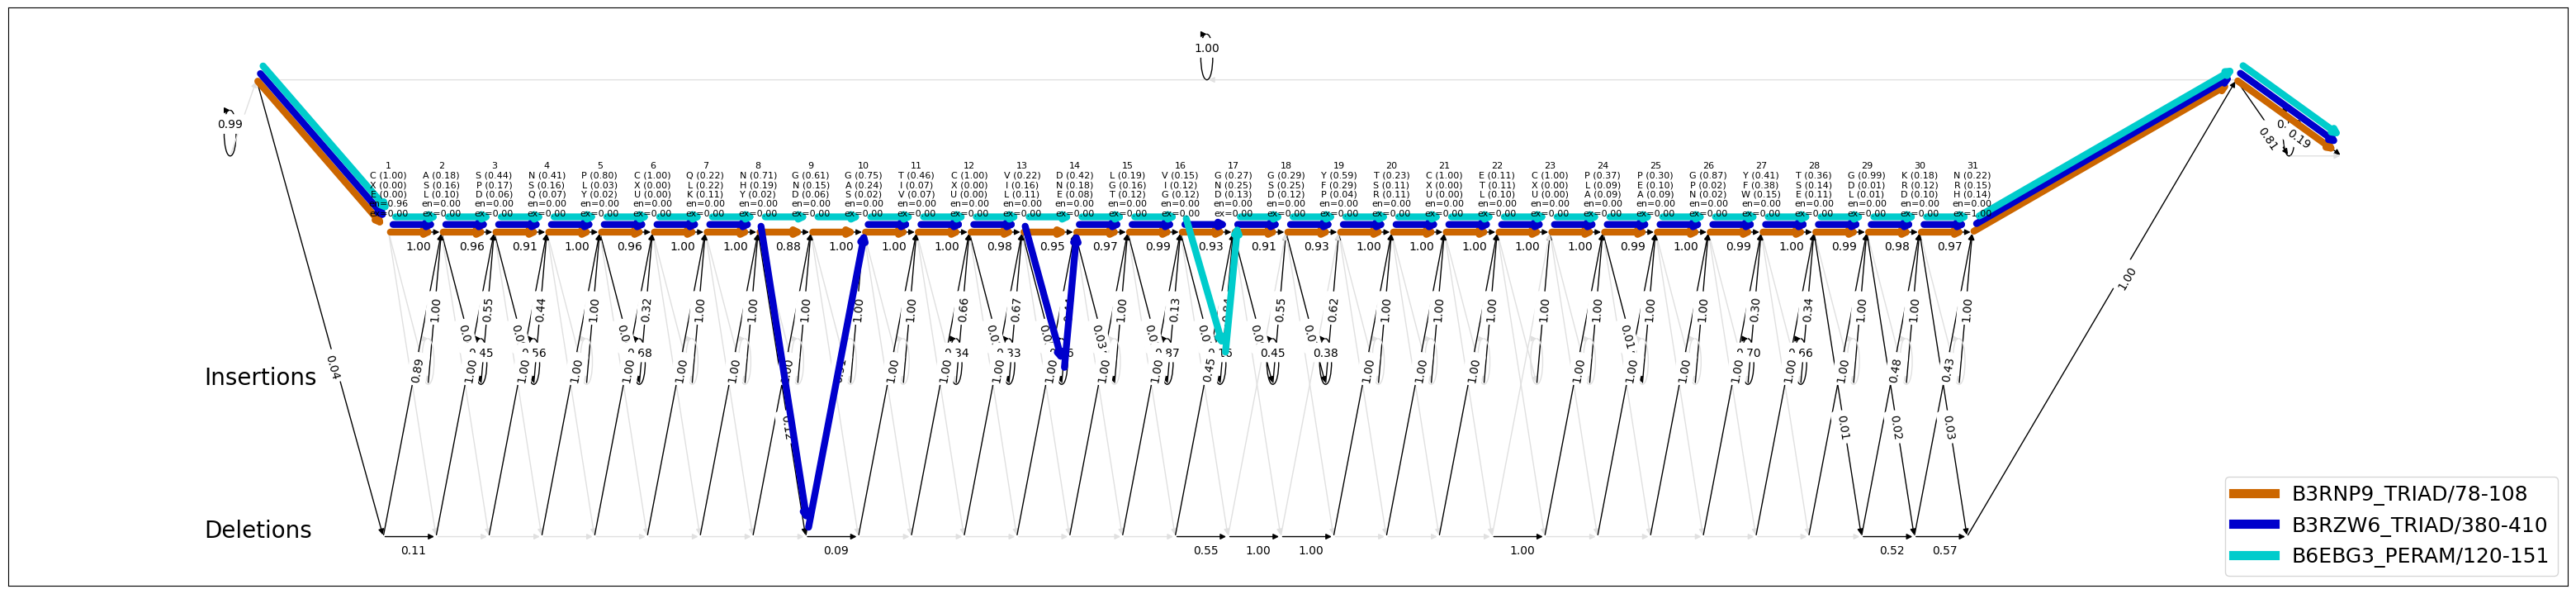

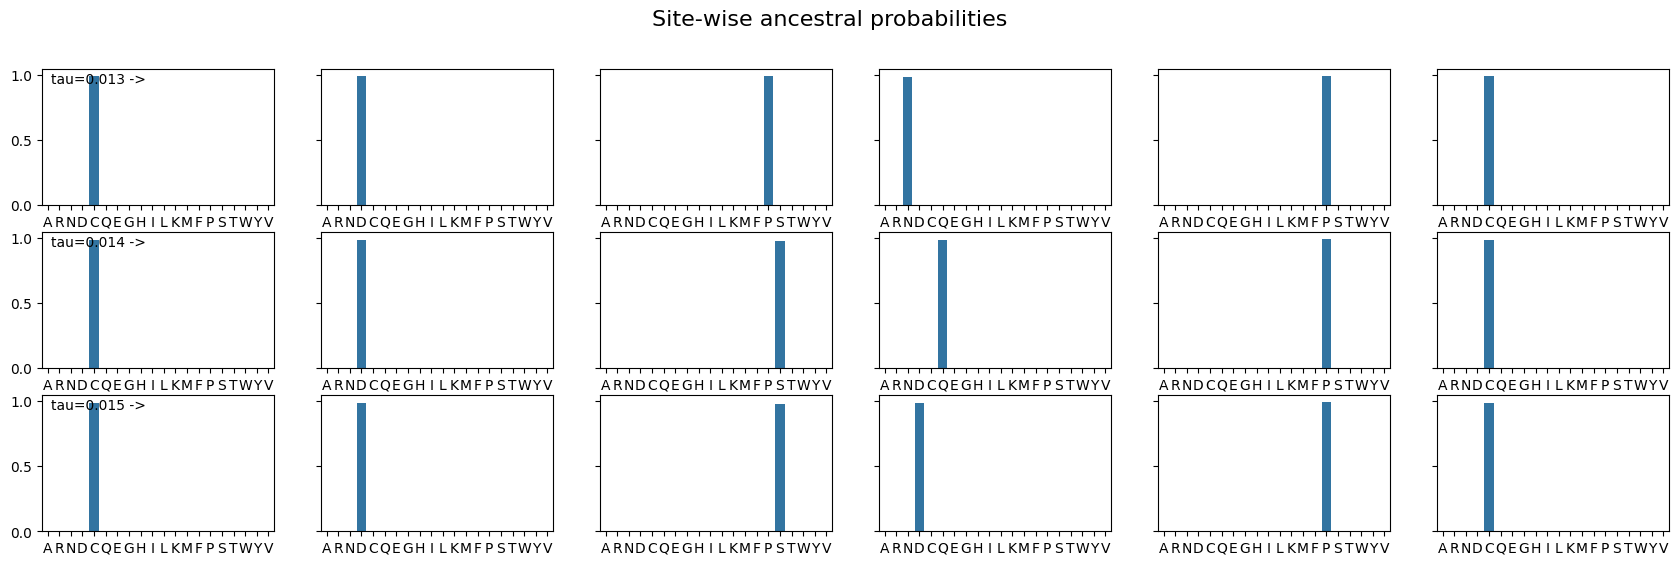

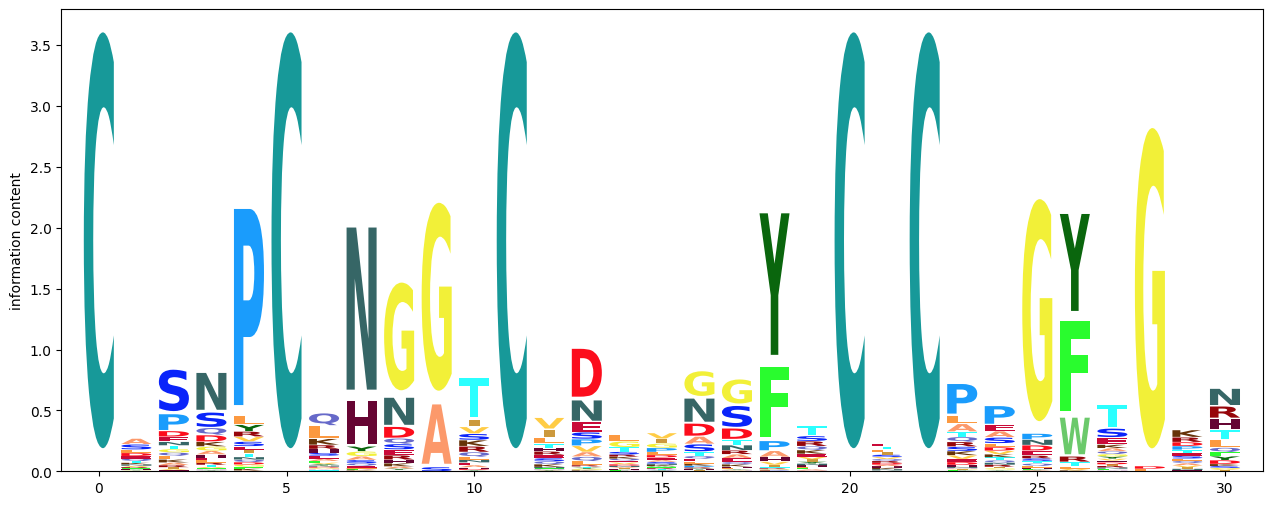

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)